In [15]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [16]:
# 1. Đọc và gộp dữ liệu từ 2 file
df_dos = pd.read_csv("data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df_normal = pd.read_csv("data/Friday-WorkingHours-Morning.pcap_ISCX.csv")
df = pd.concat([df_dos, df_normal], ignore_index=True)
print(f"File DDos: {df_dos.shape[0]} dòng, {df_dos.shape[1]} cột")
print(f"File Normal: {df_normal.shape[0]} dòng, {df_normal.shape[1]} cột")
print(f"Số dòng: {df.shape[0]}, Số cột: {df.shape[1]}")
# Kiểm tra thông tin dữ liệu
print(df.info())

File DDos: 225745 dòng, 79 cột
File Normal: 191033 dòng, 79 cột
Số dòng: 416778, Số cột: 79
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416778 entries, 0 to 416777
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             416778 non-null  int64  
 1    Flow Duration                416778 non-null  int64  
 2    Total Fwd Packets            416778 non-null  int64  
 3    Total Backward Packets       416778 non-null  int64  
 4   Total Length of Fwd Packets   416778 non-null  int64  
 5    Total Length of Bwd Packets  416778 non-null  int64  
 6    Fwd Packet Length Max        416778 non-null  int64  
 7    Fwd Packet Length Min        416778 non-null  int64  
 8    Fwd Packet Length Mean       416778 non-null  float64
 9    Fwd Packet Length Std        416778 non-null  float64
 10  Bwd Packet Length Max         416778 non-null  int64  
 11   Bwd Packet 

In [17]:
display(HTML(df.head().to_html()))

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [18]:
# 2. Xóa khoảng trắng ở đầu và cuối tên cột
df.columns = df.columns.str.strip()

In [19]:
# 3. Kiểm tra nhãn
print("Các nhãn có trong dữ liệu:")
print(df["Label"].value_counts())

Các nhãn có trong dữ liệu:
Label
BENIGN    286785
DDoS      128027
Bot         1966
Name: count, dtype: int64


In [20]:
# Xóa các dòng có nhãn "Bot"
df = df[df["Label"] != "Bot"].copy()

In [21]:
# 4. Kiểm tra giá trị NaN, trùng lặp, vô cực
print("\n🔹 Số lượng giá trị NaN:", df.isnull().sum().sum())
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("🔹 Có giá trị vô cực không:", np.isinf(df[numeric_cols].to_numpy()).sum())
print("🔹 Số dòng trùng lặp:", df.duplicated().sum())


🔹 Số lượng giá trị NaN: 32
🔹 Có giá trị vô cực không: 260
🔹 Số dòng trùng lặp: 11236


In [22]:
# 5. Xử lý NaN, Inf, Trùng
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [37]:
# Kiểm tra lại giá trị NaN, trùng lặp, vô cực
print(" - Số lượng giá trị NaN:", df.isnull().sum().sum())
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(" - Có giá trị vô cực không:", np.isinf(df[numeric_cols].to_numpy()).sum())
print(" - Số dòng trùng lặp:", df.duplicated().sum())

 - Số lượng giá trị NaN: 0
 - Có giá trị vô cực không: 0
 - Số dòng trùng lặp: 0


In [38]:
print(f"Số dòng: {df.shape[0]}, Số cột: {df.shape[1]}")

Số dòng: 403453, Số cột: 79


In [24]:
# 6. Chuẩn hóa các đặc trưng
feature_cols = [col for col in df.columns if col != "Label"]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])

In [25]:
display(HTML(df.head().to_html()))

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,2.511505,-0.461375,-0.009520,-0.010098,-0.134220,-0.007353,-0.259315,-0.160989,-0.282413,-0.234873,-0.563068,-0.52012,-0.619522,-0.52509,0.140397,4.017000,-0.379961,-0.435846,-0.426862,-0.040522,-0.442535,-0.290467,-0.393405,-0.403297,-0.103331,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.010921,-0.011486,4.186643,-0.122082,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,-0.373546,0.0,-0.013636,-0.768448,-0.692438,-0.282413,-0.619522,-0.010921,0.0,0.0,0.0,0.0,0.0,0.0,-0.009520,-0.134220,-0.010098,-0.007353,-0.463756,-0.187250,-0.007912,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,BENIGN
1,2.521648,-0.461371,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.044490,-0.059508,-0.379931,-0.435846,-0.426858,-0.040458,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,-0.100737,0.223622,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0,0.0,0.0,0.0,0.0,0.0,-0.010844,-0.135249,-0.009116,-0.007350,-0.464115,-0.151371,-0.009301,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,BENIGN
2,2.521702,-0.461373,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.038754,0.066958,-0.379947,-0.435846,-0.426860,-0.040492,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,-0.035161,0.602567,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0,0.0,0.0,0.0,0.0,0.0,-0.010844,-0.135249,-0.009116,-0.007350,-0.464115,-0.151371,-0.009301,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,BENIGN
3,2.048421,-0.461374,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.032947,0.194991,-0.379952,-0.435846,-0.426861,-0.040503,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,0.031228,0.986204,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0

In [26]:
# 7. Mã hóa nhãn
le = LabelEncoder()
df.loc[:, "Label"] = le.fit_transform(df["Label"])
print("Nhãn sau khi mã hóa:", df["Label"].value_counts())  # 0: BENIGN, 1: DDoS

Nhãn sau khi mã hóa: Label
0    275439
1    128014
Name: count, dtype: int64


In [27]:
display(HTML(df.head().to_html()))

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,2.511505,-0.461375,-0.009520,-0.010098,-0.134220,-0.007353,-0.259315,-0.160989,-0.282413,-0.234873,-0.563068,-0.52012,-0.619522,-0.52509,0.140397,4.017000,-0.379961,-0.435846,-0.426862,-0.040522,-0.442535,-0.290467,-0.393405,-0.403297,-0.103331,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.010921,-0.011486,4.186643,-0.122082,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,-0.373546,0.0,-0.013636,-0.768448,-0.692438,-0.282413,-0.619522,-0.010921,0.0,0.0,0.0,0.0,0.0,0.0,-0.009520,-0.134220,-0.010098,-0.007353,-0.463756,-0.187250,-0.007912,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,0
1,2.521648,-0.461371,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.044490,-0.059508,-0.379931,-0.435846,-0.426858,-0.040458,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,-0.100737,0.223622,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0,0.0,0.0,0.0,0.0,0.0,-0.010844,-0.135249,-0.009116,-0.007350,-0.464115,-0.151371,-0.009301,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,0
2,2.521702,-0.461373,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.038754,0.066958,-0.379947,-0.435846,-0.426860,-0.040492,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,-0.035161,0.602567,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0,0.0,0.0,0.0,0.0,0.0,-0.010844,-0.135249,-0.009116,-0.007350,-0.464115,-0.151371,-0.009301,-0.587754,-0.170446,-0.087401,-0.178695,-0.159447,-0.398218,-0.214539,-0.400465,-0.346116,0
3,2.048421,-0.461374,-0.010844,-0.009116,-0.135249,-0.007351,-0.259315,-0.160989,-0.282413,-0.234873,-0.561100,-0.43404,-0.613066,-0.52509,-0.032947,0.194991,-0.379952,-0.435846,-0.426861,-0.040503,-0.442535,-0.290467,-0.393405,-0.403297,-0.103332,-0.328246,-0.189247,-0.27094,-0.282001,-0.105514,-0.209241,0.0,0.0,0.0,-0.012176,-0.010509,0.031228,0.986204,-0.370268,-0.622021,-0.692561,-0.623727,-0.474296,-0.062463,-0.209241,-0.013636,-0.655856,1.23447,2.677045,0.0,-0.013636,0.114273,-0.692438,-0.282413,-0.613066,-0.012176,0.0,0.0,0.0,0.0,0.

In [29]:
df["Label"] = df["Label"].astype(int)

In [30]:
# 9. Tính MI và vẽ biểu đồ
mi_scores = mutual_info_classif(df[feature_cols], df["Label"], discrete_features=False)
mi_scores = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)

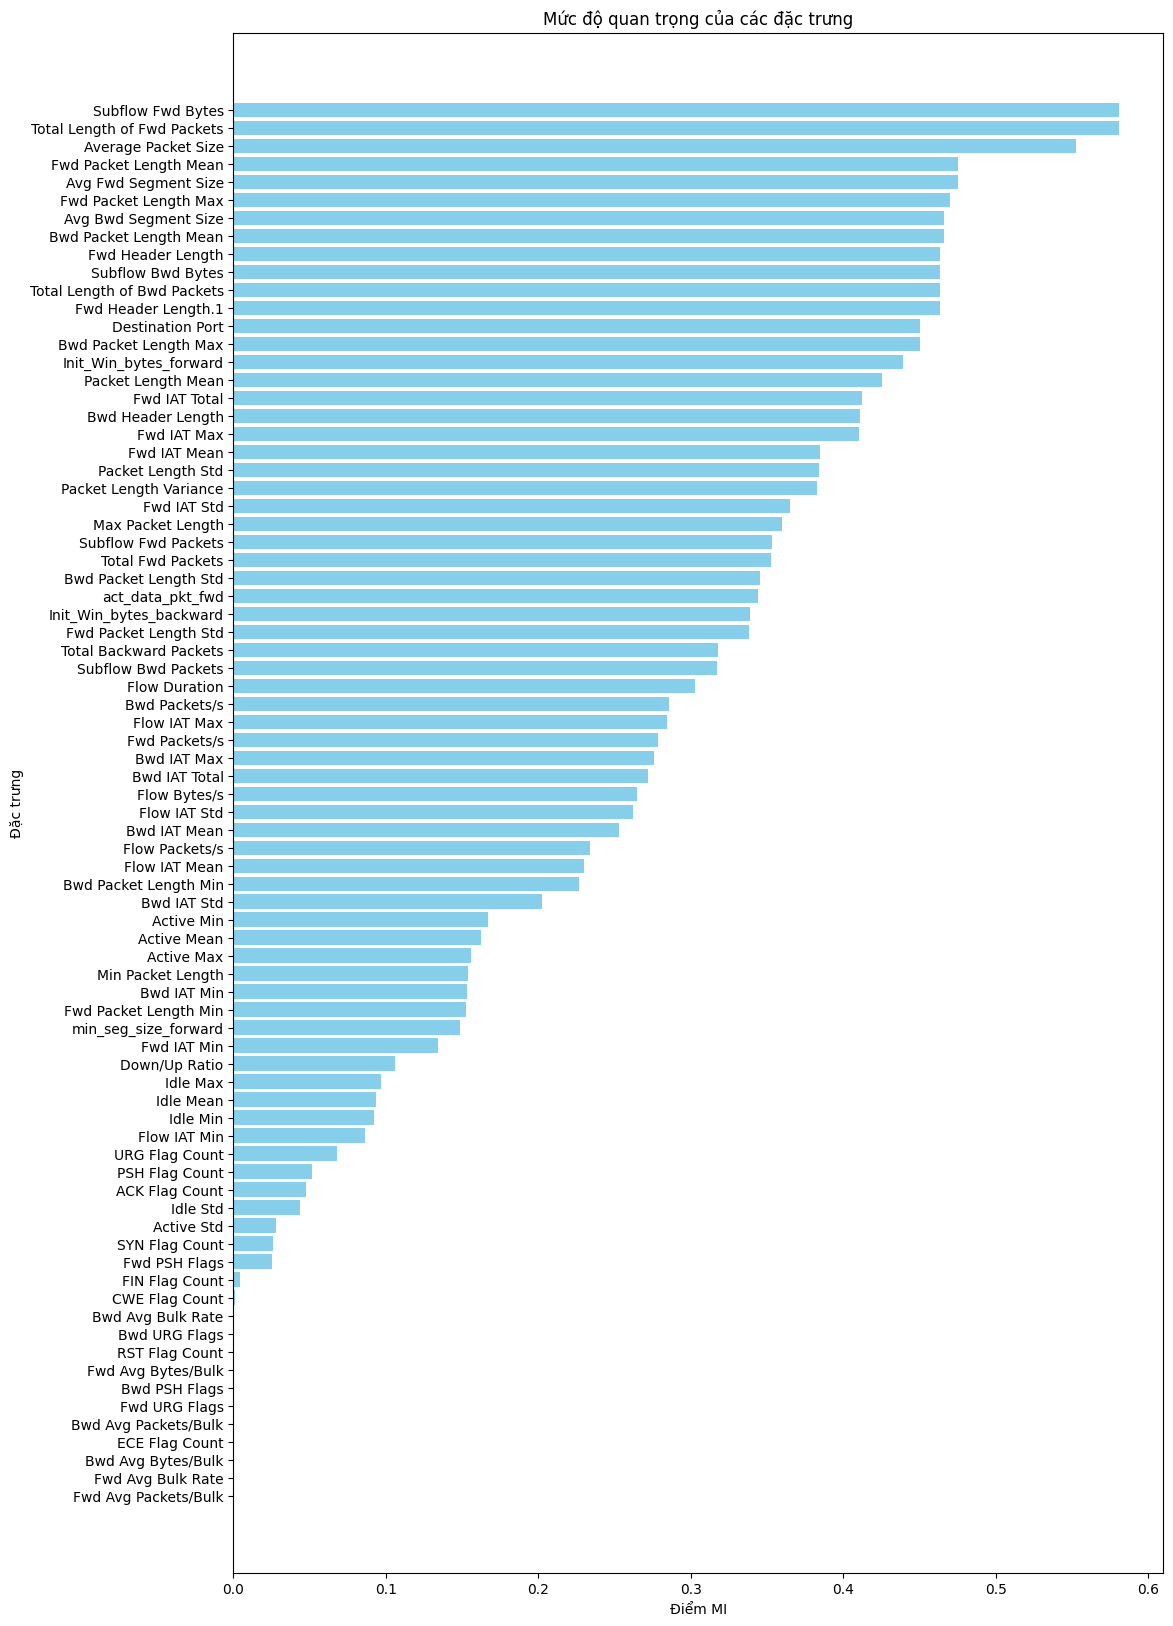

In [31]:
plt.figure(figsize=(12, 20))
plt.barh(mi_scores.index, mi_scores.values, color="skyblue")
plt.xlabel("Điểm MI")
plt.ylabel("Đặc trưng")
plt.title("Mức độ quan trọng của các đặc trưng")
plt.gca().invert_yaxis()
plt.show()

In [32]:
# 10. Chọn các đặc trưng có MI > 0.3
selected_features = mi_scores[mi_scores > 0.3].index.tolist()
df_selected = df[selected_features + ["Label"]]

In [33]:
# 11. Tách dữ liệu 70-30
X = df_selected.drop(columns=["Label"])
y = df_selected["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Số mẫu trong tập huấn luyện (X_train):", len(X_train))
print("Số mẫu trong tập kiểm tra (X_test):", len(X_test))

Số mẫu trong tập huấn luyện (X_train): 282417
Số mẫu trong tập kiểm tra (X_test): 121036


In [35]:
# 12. Huấn luyện và đánh giá mô hình Naive Bayes
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("\n🔹 Độ chính xác:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


🔹 Độ chính xác: 0.9559304669685053

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97     82632
           1       0.88      1.00      0.94     38404

    accuracy                           0.96    121036
   macro avg       0.94      0.97      0.95    121036
weighted avg       0.96      0.96      0.96    121036


Confusion Matrix:
 [[77299  5333]
 [    1 38403]]


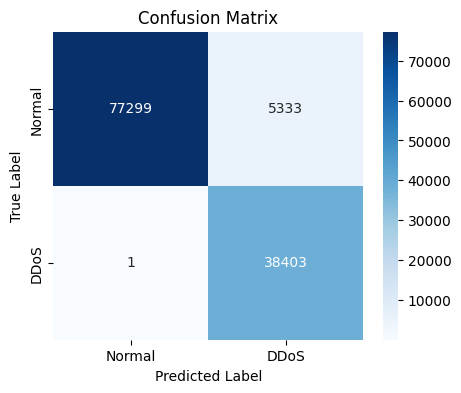

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "DDoS"], yticklabels=["Normal", "DDoS"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()